In [1]:
import yfinance as yf
import pandas as pd

In [2]:
# Download Bitcoin price data
df = yf.download(
    "BTC-USD",
    interval="1d",
    period="730d"
)

df.head()

/var/folders/2w/h1bt4559471_khrg5vdk5vtm0000gn/T/ipykernel_1980/3362711806.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2023-12-27,43442.855469,43683.160156,42167.582031,42518.468750,25260941032
2023-12-28,42627.855469,43804.781250,42318.550781,43468.199219,22992093014
2023-12-29,42099.402344,43124.324219,41424.062500,42614.644531,26000021055
2023-12-30,42156.902344,42584.125000,41556.226562,42091.753906,16013925945
2023-12-31,42265.187500,42860.937500,41998.253906,42152.097656,16397498810


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-12-27 to 2025-12-25
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   730 non-null    float64
 1   (High, BTC-USD)    730 non-null    float64
 2   (Low, BTC-USD)     730 non-null    float64
 3   (Open, BTC-USD)    730 non-null    float64
 4   (Volume, BTC-USD)  730 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 34.2 KB


In [4]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

## Visualizing the price

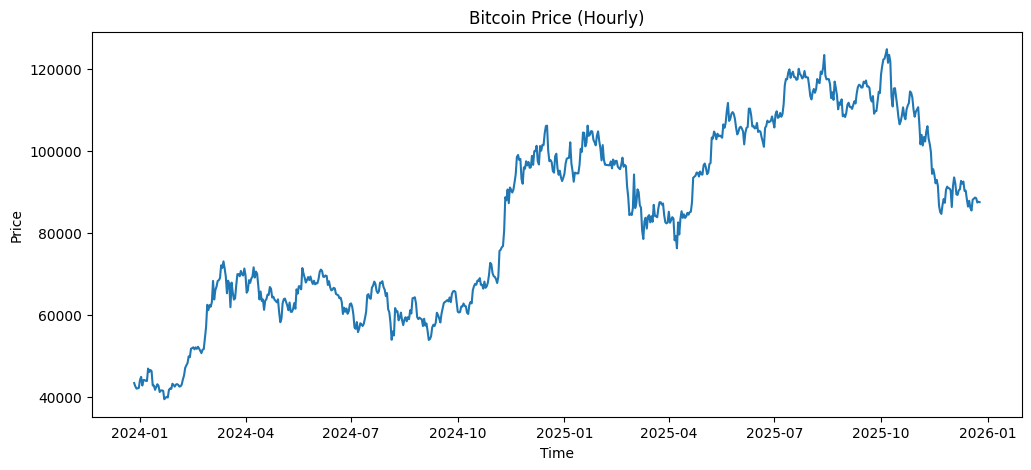

In [5]:
#plot closing price
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"])
plt.title("Bitcoin Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()



In [6]:
df.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [7]:
df.columns = df.columns.get_level_values(0)

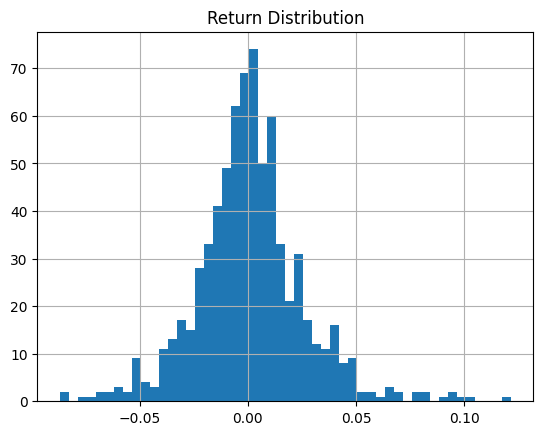

In [8]:
#look at returns(core financial concept)
df["return"] = df["Close"].pct_change()
df["return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()


## Feature Engineering

In [9]:
#price based features
df["return"] = df["Close"].pct_change()
df["hl_range"] = (df["High"] - df["Low"]) / df["Close"]
df["co_change"] = (df["Close"] - df["Open"]) / df["Open"]


In [10]:
#moving averages(SMA-simple moving average)
df["sma_10"] = df["Close"].rolling(10).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["sma_50"] = df["Close"].rolling(50).mean()

In [11]:
# Exponential moving average(EMA)
#ema reacts faster than sma

df["ema_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["ema_26"] = df["Close"].ewm(span=26, adjust=False).mean()

In [12]:
# RSI — Momentum & Psychology
# RSI intuition
# RSI > 70 → market overbought
# RSI < 30 → market oversold
# But ML uses RSI as a continuous signal, not rules.

from ta.momentum import RSIIndicator
rsi = RSIIndicator(close=df["Close"],window=14)
df["rsi"] = rsi.rsi()

In [13]:
# MACD — Trend + Momentum Combo
# MACD = EMA(12) − EMA(26)

from ta.trend import MACD
macd = MACD(close=df["Close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()

In [14]:
# Volume features (CONFIRMATION)
# Market truth
# Strong moves need volume

df["vol_change"] = df["Volume"].pct_change()
df["vol_ma_20"] = df["Volume"].rolling(20).mean()

In [15]:
# Normalize trend features 
# Raw prices are bad for ML.

df["price_sma10_ratio"] = df["Close"] / df["sma_10"]
df["price_sma20_ratio"] = df["Close"] / df["sma_20"]
df["price_sma50_ratio"] = df["Close"] / df["sma_50"]


In [16]:
# handling missing values
df = df.dropna()

## Label Creation & Target Variable

In [17]:
# Define the prediction horizon 

# We must decide:
# - How far into the future we predictOur choice:
# 1-hour ahead direction
# Why 1 hour?
# - Short-term signal exists
# - Not too noisy like 1 minute
# - Not too slow like daily

In [18]:
#Define the label mathematically
df["future_close"] = df["Close"].shift(-1)
df["target"] = (df["future_close"] > df["Close"]).astype(int)

In [19]:
# Removing the last row 
df = df.dropna()

In [20]:
# Sanity check your label 
df["target"].value_counts(normalize=True)

target
1    0.505882
0    0.494118
Name: proportion, dtype: float64

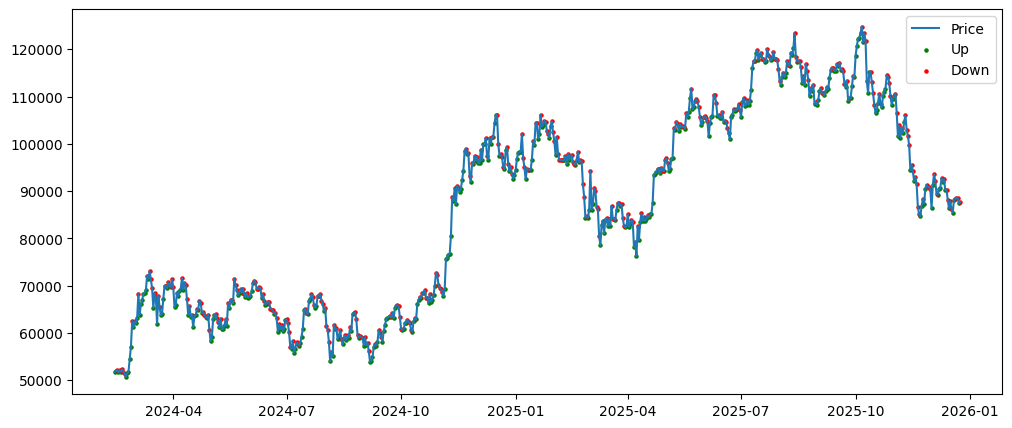

In [21]:
# Visual intuition

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index,df["Close"], label="Price")

up = df[df["target"] == 1]
down = df[df["target"] == 0]

plt.scatter(up.index, up["Close"], color="green", s=5, label="Up")
plt.scatter(down.index, down["Close"], color="red", s=5, label="Down")

plt.legend()
plt.show()


In [22]:
# Define feature matrix(X) and target(y)
feature_cols = [
    "return", "hl_range", "co_change",
    "price_sma10_ratio", "price_sma20_ratio", "price_sma50_ratio",
    "ema_12", "ema_26",
    "rsi", "macd", "macd_signal",
    "vol_change", "vol_ma_20"
]

X = df[feature_cols]
y = df["target"]


In [23]:
# Why we don’t scale yet
# Tree-based models (Random Forest):
# Don’t need scaling
# Handle different feature ranges
# So:
# Scaling comes later (if needed)

## Train / Test Split for Time-Series Data

In [24]:
#time based split

# PAST -------------------- FUTURE
# |        TRAIN        |   TEST   |


split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


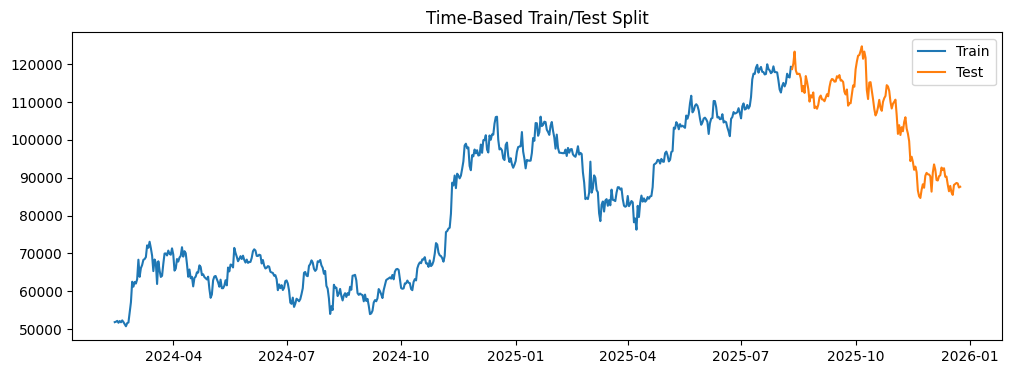

In [25]:
# visual sanity check

plt.figure(figsize=(12,4))
plt.plot(df.index[:split_index], df["Close"][:split_index], label="Train")
plt.plot(df.index[split_index:], df["Close"][split_index:], label="Test")
plt.legend()
plt.title("Time-Based Train/Test Split")
plt.show()


In [26]:
# prep data for modeling

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())


(544, 13) (136, 13)
0.5128676470588235 0.47794117647058826


## Baseline Model: Logistic Regression

In [ ]:
#prepare data for logistic regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# train the logistic regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [29]:
#make predictions 
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

In [30]:
#Evaluate classification performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5147058823529411
[[42 29]
 [37 28]]
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        71
           1       0.49      0.43      0.46        65

    accuracy                           0.51       136
   macro avg       0.51      0.51      0.51       136
weighted avg       0.51      0.51      0.51       136



In [31]:
#interpret model coefficient
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
4,price_sma20_ratio,0.278770
5,price_sma50_ratio,0.259779
10,macd_signal,0.193917
8,rsi,0.163030
1,hl_range,0.086947
7,ema_26,0.016214
12,vol_ma_20,0.005159
11,vol_change,-0.022377
6,ema_12,-0.050215
0,return,-0.062967


In [32]:
#probabity thresold
y_pred_custom = (y_prob > 0.55).astype(int)